# KinMS galaxy fitting tutorial

This tutorial aims at getting you up and running with galaxy kinematic modelling using _KinMS_! 

<b>NOTE: I really recommend that you use [KinMS_fitter](https://github.com/TimothyADavis/KinMS_fitter) for galaxy fitting - but I keep this tutorial online in case you need more fine control of your fitting process.</b>

To start you will need to download the KinMSpy code and have it in your python path. To do this you can simply call `pip install kinms`

To get started with kinematic modelling we will complete the following steps:
1. Generate a model to fit (can be skipped if you have your own observed data cube)
2. Read in that cube, and extract the important information from the header
3. Fit the data using an MCMC code

We will start by importing a variety of modules we will need to work with KinMS, and plot its output.

In [2]:
from kinms import KinMS
import numpy as np
from astropy.io import fits
from kinms.utils.KinMS_figures import KinMS_plotter

## Generate a model

First we will generate a simple galaxy model using KinMS itself, that we can attempt to determine the parameters of later. If you have your own observed galaxy to fit then of course this step can be skipped!

The `make_model` function below creates a simple exponential disc:

$
\begin{align}
\large \Sigma_{H2}(r) \propto e^{\frac{-r}{d_{scale}}}
\end{align}
$

with a circular velocity profile which is parameterized using an arctan function:

$
\begin{align}
\large V(r) = \frac{2V_{flat}}{\pi} \arctan\left(\frac{r}{r_{turn}}\right)
\end{align}
$



In [3]:
def make_model(param,kinms_instance,rad,filename=None,plot=False):
    '''
    This function takes in the `param` array (along with obspars; the observational setup,
    and a radius vector `rad`) and uses it to create a KinMS model.
    '''
    
    total_flux=param[0]
    posAng=param[1]
    inc=param[2]
    v_flat=param[3]
    r_turn=param[4]
    scalerad=param[5]
    
    ### Here we use an exponential disk model for the surface brightness of the gas ###
    sbprof = np.exp((-1)*rad/scalerad)

    ### We use a very simple arctan rotation curve model with two free parameters. ###
    vel=(v_flat*2/np.pi)*np.arctan(rad/r_turn)

    ### This returns the model
    return kinms_instance.model_cube(inc,sbProf=sbprof,sbRad=rad,velRad=rad,velProf=vel,\
                 intFlux=total_flux,posAng=posAng,fileName=filename,toplot=plot)
 

Now we have our model function, lets use it to generate a model which we will later fit. The first thing we need is to define the setup of our desired datacube (typically if you are fitting real data this will all be determined from the header keywords- see below), and set up a KinMS instance with these parameters.

In [5]:
### Setup cube parameters ###
obspars={}
obspars['xsize']=64.0 # arcseconds
obspars['ysize']=64.0 # arcseconds
obspars['vsize']=500.0 # km/s
obspars['cellsize']=1.0 # arcseconds/pixel
obspars['dv']=20.0 # km/s/channel
obspars['beamsize']=np.array([4.0,4.0,0]) # [bmaj,bmin,bpa] in (arcsec, arcsec, degrees)

kin=KinMS(obspars['xsize'],obspars['ysize'],obspars['vsize'],obspars['cellsize'],obspars['dv'],\
                 obspars['beamsize'])


We also need to create a radius vector- you ideally want this to oversample your pixel grid somewhat to avoid interpolation errors!

In [6]:
rad=np.arange(0,100,0.3)

Now we have all the ingredients we can create our data to fit. Here we will also output the model to disc, so we can demonstrate how to read in the header keywords from real ALMA/VLA etc data. 

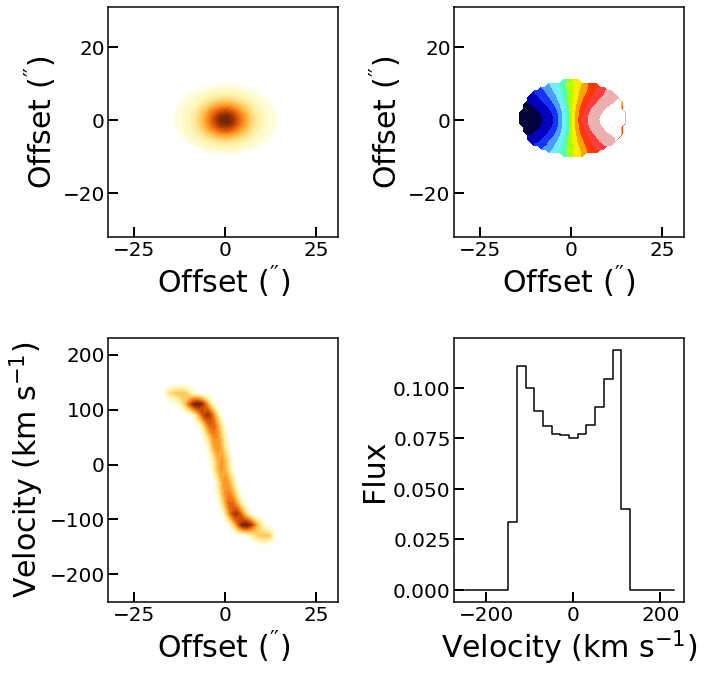

In [7]:
'''
True values for the flux, posang, inc etc, as defined in the model function
'''

guesses=np.array([30.,270.,45.,200.,2.,5.]) 

'''
RMS of data. Here we are making our own model so this is arbitary. 
When fitting real data this should be the observational RMS
'''
error=np.array(1e-3)


fdata=make_model(guesses,kin,rad, filename="Test",plot=True)

## Read in the data

In this example we already have our data in memory. But if you are fitting a real datacube this wont be the case!  Here we read in the model we just created from a FITS file to make it clear how to do this.

In [8]:
### Load in your observational data ###
hdulist = fits.open('Test_simcube.fits',ignore_blank=True)
fdata = hdulist[0].data.T 


### Setup cube parameters ###
obspars={}
obspars['cellsize']=np.abs(hdulist[0].header['cdelt1']*3600.) # arcseconds/pixel
obspars['dv']=np.abs(hdulist[0].header['cdelt3']/1e3) # km/s/channel
obspars['xsize']=hdulist[0].header['naxis1']*obspars['cellsize'] # arcseconds
obspars['ysize']=hdulist[0].header['naxis2']*obspars['cellsize'] # arcseconds
obspars['vsize']=hdulist[0].header['naxis3']*obspars['dv'] # km/s
obspars['beamsize']=np.array([hdulist[0].header['bmaj']*3600.,hdulist[0].header['bmin']*3600.,hdulist[0].header['bpa']])# [bmaj,bmin,bpa] in (arcsec, arcsec, degrees)

kin=KinMS(obspars['xsize'],obspars['ysize'],obspars['vsize'],obspars['cellsize'],obspars['dv'],\
                 obspars['beamsize'])



## Fit the model

Now we have our 'observational' data read into memory, and a model function defined, we can fit one to the other! As our fake model is currently noiseless, lets add some gaussian noise (obviously dont do this if your data is from a real telecope!):

In [9]:
fdata+=(np.random.normal(size=fdata.shape)*error)

Below we will proceed using the MCMC code GAStimator which was specifically designed to work with KinMS, however any minimiser should work in principle. For full details of how this code works, and a tutorial, see https://github.com/TimothyADavis/GAStimator .

In [13]:
from gastimator import gastimator,corner_plot

mcmc = gastimator(make_model,kin,rad)

mcmc.labels=np.array(['Flux','posAng',"Inc","VFlat","R_turn","scalerad"])
mcmc.min=np.array([30.,1.,10,50,0.1,0.1])
mcmc.max=np.array([30.,360.,80,400,20,10])
mcmc.fixed=np.array([True,False,False,False,False,False])
mcmc.precision=np.array([1.,1.,1.,10,0.1,0.1])
mcmc.guesses=np.array([30.,275.,55.,210.,2.5,4.5]) #starting guesses, purposefully off!
mcmc.nprocesses=2 # for running a short chain you dont want to split it between too many processors!

Setting good priors on the flux of your source is crucial to ensure the model outputs are physical. Luckily the integrated flux of your source should be easy to measure from your datacube! If you have a good measurement of this, then I would recommend forcing the total flux to that value by fixing it in the model (set `mcmc.fixed=True` for that parameter). If you can only get a guess then set as tight a prior as you can. This stops the model hiding bad fitting components below the noise level. 

Its always a good idea to plot your model over your data before you start a fitting processes. That allows you to check that the model is reasonable, and tweak the parameters by hand to get good starting guesses. Firs you should generate a cube from your model function, then you can overplot it on your data using the simple plotting tool included with KinMS:

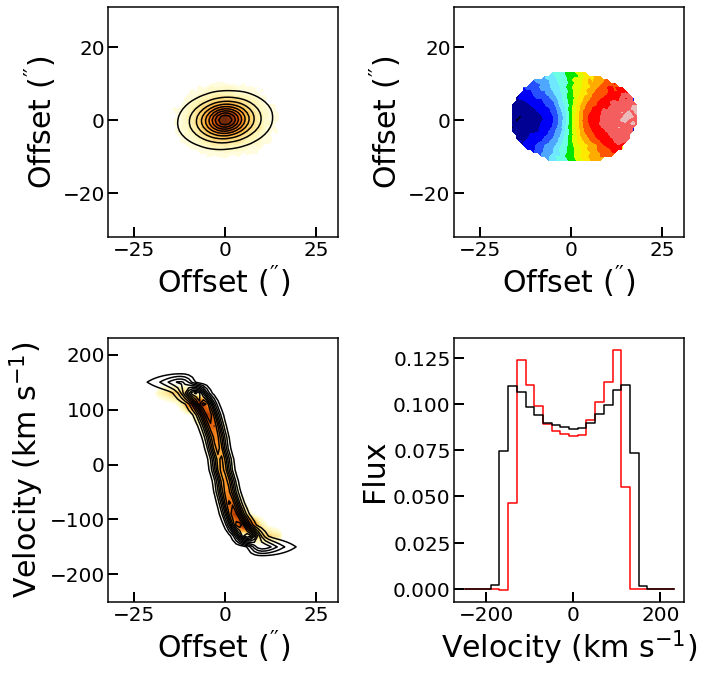

In [14]:
model=make_model(mcmc.guesses,kin,rad) # make a model from your guesses

KinMS_plotter(fdata, obspars['xsize'], obspars['ysize'], obspars['vsize'], obspars['cellsize'],\
              obspars['dv'], obspars['beamsize'], posang=guesses[1],overcube=model,rms=error).makeplots()

As you can see, the black contours of the model arent a perfect match to the moment zero, spectrum and position-velocity diagram extracted from our "observed" datacube. One could tweak by hand, but as these are already close we can go on to do a fit! 

If you are experimenting then running until convergence should be good enough to get an idea if the model is physical (setting a low number of iterations, ~3000 works for me).

In [15]:
outputvalue, outputll= mcmc.run(fdata,error,3000,plot=False)

Doing chain 1
     Chain 0 has not converged - Accept rate: 0.03
     Chain 0 has not converged - Accept rate: 0.07666666666666666
     --> Still varying: ['posAng' 'R_turn']
Chain 0 converged: LL: -5677.595822319352 - Accept rate:0.2966666666666667
Best chain so far!
Best fit:
  Flux: 30.0
  posAng: 269.9836542934303
  Inc: 42.29327534754347
  VFlat: 209.69876018484206
  R_turn: 1.9941243496997856
  scalerad: 4.688000690759903
Starting final chain


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
100%|█████████▉| 2998/3000 [03:21<00:00, 14.88it/s]
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.4min finished


Final best fit values and 1sigma errors:
  Flux: 30.0 (Fixed)
  posAng: 269.9892879721465 + 0.041303107499857106 - 0.047282096367553095
  Inc: 42.94341417542115 + 0.23556411544573308 - 0.21238073671227653
  VFlat: 207.3195734603511 ± 0.9619070031107242
  R_turn: 1.995626673828506 ± 0.009050681015496331
  scalerad: 4.698408536960731 + 0.021247899201844334 - 0.010243835274440727


As you can see, the final parameters (listed in the output with their 1sigma errors) are pretty close to those we input! One could use the cornor_plot routine shipped with GAStimator to visualize our results, but with only 3000 steps (and a $\approx$30% acceptance rate) these wont be very pretty. If you need good error estimates/nice looking cornor plots for publication then I recommend at least 30,000 iterations, which may take several hours/days depending on your system, and the size of your datacube. 


One can visualize the best-fit model again to check how we did - turns out pretty well! (Note the flux in the integrated spectrum isnt perfect, this is because of the masking of the noisy data). 

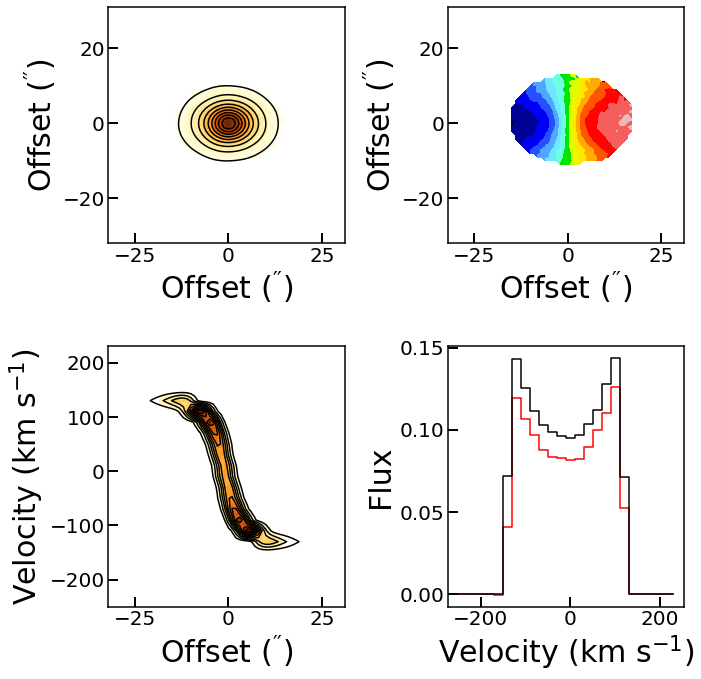

In [21]:
bestmodel=make_model(np.median(outputvalue,1),kin,rad) # make a model from your guesses

KinMS_plotter(fdata, obspars['xsize'], obspars['ysize'], obspars['vsize'], obspars['cellsize'],\
              obspars['dv'], obspars['beamsize'], posang=guesses[1],overcube=bestmodel,rms=error).makeplots()

## Tiny error problem

I have found that fitting whole datacubes with kinematic modelling tools such as KinMS can yield unphysically small uncertanties, for instance constraining inclination to $\pm\approx0.1^{\circ}$ in the fit example performed above. This is essentially a form of model mismatch - you are finding the very best model _of a given type_ that fits the data - and as you have a large number of free-parameters in a data cube you can find the best model (no matter how bad it is at actually fitting the data!) really well. 

In works such as [Smith et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.4359S/abstract) we have attempted to get around by taking into account the variance of the $\chi^2$ statistic.

As observed data are noisy, the $\chi^2$ statistic has an additional uncertainty associated with it, following the chi-squared distribution ([Andrae 2010](https://ui.adsabs.harvard.edu/abs/2010arXiv1009.2755A/abstract)). This distribution has a variance of $2(N - P)$, where $N$ is the number of constraints and $P$ the number of inferred parameters. For fitting datacubes $N$ is very large, so the variance becomes $\approx2N$. 
Systematic effects can produce variations of $\chi^2$ of the order of this variance, and ignoring this effect yields unrealistically small uncertainty estimates. In order to mitigate this effect [van
den Bosch & van de Ven (2009)](https://ui.adsabs.harvard.edu/abs/2009MNRAS.398.1117V/abstract) proposed to increase the $1\sigma$ confidence interval to $\Delta\chi^2=\sqrt{2N}$. To achieve the same effect within the Bayesian MCMC approach discussed above we need to scale the log-likelihood, by increasing the RMS estimate provided to GAStimator  by $(2N)^{1/4}$. This approach appears to yield physically credible formal uncertainties in the inferred parameters, whereas otherwise these uncertainties are unphysically small. 

Lets try that with the example above:

In [22]:
error*=((2.0*fdata.size)**(0.25))
outputvalue, outputll= mcmc.run(fdata,error,3000,plot=False)

Doing chain 1
     Chain 0 has not converged - Accept rate: 0.14
     Chain 0 has not converged - Accept rate: 0.27666666666666667
     --> Still varying: ['Inc' 'VFlat' 'R_turn' 'scalerad']
     Chain 0 has not converged - Accept rate: 0.48333333333333334
     --> Still varying: ['Inc' 'R_turn' 'scalerad']
     Chain 0 has not converged - Accept rate: 0.53
     --> Still varying: ['Inc' 'R_turn' 'scalerad']
     Chain 0 has not converged - Accept rate: 0.4666666666666667
     --> Still varying: ['R_turn']
     Chain 0 has not converged - Accept rate: 0.5266666666666666
     --> Still varying: ['R_turn']
     Chain 0 has not converged - Accept rate: 0.5
     --> Still varying: ['Inc' 'R_turn']
     Chain 0 has not converged - Accept rate: 0.48333333333333334
     --> Still varying: ['Inc' 'scalerad']
Chain 0 converged: LL: -16.051449855213974 - Accept rate:0.5466666666666666
Best chain so far!
Best fit:
  Flux: 30.0
  posAng: 270.03726632741405
  Inc: 48.78384312606832
  VFlat: 186.638

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
100%|█████████▉| 2998/3000 [03:38<00:00, 13.74it/s]
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.7min finished


Final best fit values and 1sigma errors:
  Flux: 30.0 (Fixed)
  posAng: 270.0078976995622 + 0.7967594699223355 - 0.9389069522926548
  Inc: 47.64694464844241 + 1.1868057699978962 - 1.4441434659114663
  VFlat: 190.18674325252377 + 6.1478132315800735 - 2.563261374626478
  R_turn: 1.925266867450474 + 0.16855888768787008 - 0.19692776201711304
  scalerad: 4.8281261829583695 + 0.24117377725407163 - 0.19129519094394087


As you can see we now get a much more reasonable error estimates, for instance a 1$\sigma$ inclination error of $\approx\pm1.5^{\circ}$. 

If you want to implement this fix yourself there is a wrinkle to consider. You need to be careful choosing $N$. Formally this should be the number of constraints- i.e. the total number of pixels in your cube. But consider a large datacube with signal only in a small section (although fitting such a datacube would be inefficient anyway; see speed tips below), all of the actual constraints are coming from a small number of pixels.  If you find yourself in this situation I would recommend setting $N$ to the number of pixels with actual detected flux in your datacube.  

## Speed tips

There are some common ways to make sure you don't spend a lot of time MCMCing rather than doing science. 

- Cut down your observed data to only include spaxels and frequency channels near signal. Ideally you want some padding around your observed signal so the model knows it must not include flux in those positions, but not so much as to drastically increase runtime! On a similar note...<p>

- Make sure your observed data (and thus models) have spatial dimensions that are $2^n$. If this is impossible then $3^n$ and $6^n$ are pretty good too. This is because convolving the KinMS model with the beam takes the majority of the computation time, and FFTs are faster when working with such dimensions.<p>

- Don't provide a radius vector that is very oversampled/overlong well beyond the projected dimensions of the cube. This can slow down internal interpolation routines.